# Отбор коров для молочного хозяйства

В компанию поступил заказ на проект по машинному обучению. К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров - по качеству молока и величине удоя. Фермер хочет, чтобы каждая бурёнка давала **не менее 6000 килограммов молока в год**, а надой был **вкусным** — строго по его критериям, ничуть не хуже. 

Чтобы не дать себя обмануть и строго по параметрам подобрать коров для покупки, фермер просит нас создать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. 

**Цель:**
В результате проекта нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать **возможный удой** у коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить **вкусное молоко** от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
- Средний удой за год — **не менее 6000 килограммов**,
- Молоко должно быть **вкусным**.

Для исследования переданы три файла:
- файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент - параметры корма коровы, где паслась корова, особенности коровы, характеристика молока . 
- файл `ferma_dad.csv` хранит имя отца каждой коровы в стаде фермера.
- файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична `ferma_main.csv`, кроме нескольких особенностей: 
1. белок и жирность молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.
2. Параметры кормления ЭКЕ, Сырой протеин, СПО отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. Именно новые параметры нужно использовать, когда вы будете применять предсказательные модели к бурёнкам «ЭкоФермы». *По новой схеме фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.*
3. Удой и Вкус молока неизвестны —  их необходимо предсказать.

Исследование пройдёт в несколько этапов:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных
4. Обучение моделей (линейной и логистической регрессии).


## 1. Обзор данных

In [1]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error , r2_score, recall_score, accuracy_score, precision_score, confusion_matrix
from Levenshtein import distance as lev
#чтобы не появлялись предупреждения
import warnings
warnings.simplefilter("ignore")

In [2]:
#функция для подготовки данных к МО
def get_ready(X,y, cat_col_names, num_col_names):
    
    """Эта функция подготавливает данные для машинного обучения.

    На вход подаются входные признаки, таргет, 
    названия колонок категориальных и количественных входных признаков. 
    Сначала функция разделяет выборку, затем изменяет категориальные данные
    методом OneHotEncoder(), далее стандартизирует числовые данные. 
    На выходе получаем тренировочную и тестовую выборки.
    """
    
    # разделяем выборку 
    RANDOM_STATE = 42

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    )
    # изменяем категории, с учетом избегания дамми-ловушек
    encoder = OneHotEncoder(drop = 'first', sparse = False)

    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

    X_test_ohe = encoder.transform(X_test[cat_col_names])
    # стандартизуем масштаб количественных данных 
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train[num_col_names])

    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    # соединяем воедино количественные и качественные признаки
    encoder_col_names = encoder.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    return X_train, X_test, y_train, y_test, scaler, encoder

In [3]:
# функция посчета метрик линейной регрессии
def lin_reg_metrics(y_test, predictions,variant_num):
    
    """Эта функция проводит рассчитывает метрики, 
     оценивающие качество и точность линейной регресии .

    На вход подаются реальные значения таргета из тестовой выборки и наши предсказания, 
    а также название/номер модели. 
    Функция рассчитывает MAE, MSЕ, RMSE и R2. Выдает эти метрики в виде таблицы.
    """
    
    return pd.DataFrame({'var_lin_reg' : variant_num,
                         'MAE':[mean_absolute_error(y_test, predictions)], 
                         'MSE':[mean_squared_error(y_test, predictions)],
                         'RMSE':[mean_squared_error(y_test, predictions, squared=False)], 
                         'R2':[r2_score(y_test, predictions)]})

In [4]:
#функция для анализа остатков
def residuals(y_test,  predictions):
    
    """Эта функция проводит анализ остатков для проверки качества модели.

    На вход подаются реальные значения таргета из тестовой выборки и наши предсказания. 
    Функция стоит гистограмму распределения остатков 
    и ящик с усами для анализа дисперсии остатков.
    На выходе получаем два графика.
    """
    
#  рассчитаем остатки
    residuals = y_test - predictions

# построим гистограмму частотности распределения и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(x = residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(y =residuals, x =  predictions)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

In [5]:
def clf_metrics(y_test, predictions,clf):
    
    """Эта функция проводит рассчитывает метрики, 
     оценивающие качество и точность классификатора .

    На вход подаются реальные значения таргета из тестовой выборки и наши предсказания, 
    а также название/номер модели-классификатора. 
    Функция рассчитывает accuracy, precision, recall . Выдает эти метрики в виде таблицы.
    """
    
    return pd.DataFrame({'clf' : [clf],
                         'accuracy':[accuracy_score(y_test, predictions)], 
                         'precision':[precision_score(y_test, predictions)],
                         'recall':[recall_score(y_test, predictions)], 
                         })

In [6]:
#открываем файлы и записываем в переменные - столбцы разделены точкой с запятой, а числовые данные записаны с запятой
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';', decimal=',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';', decimal=',')
except:
    ferma_main = pd.read_csv('ferma_main.csv', sep = ';', decimal=',')
    ferma_dad = pd.read_csv('ferma_dad.csv', sep = ';')
    cow_buy = pd.read_csv('cow_buy.csv', sep = ';', decimal=',')

### 1.1 Данные о коровах фермера

In [7]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [8]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [9]:
ferma_main.describe()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,14.542744,1922.682965,0.912855,3.603943,3.075666
std,183.096982,1638.401021,1.301301,182.392548,0.032209,0.168020,0.002540
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,159.250000,5751.750000,13.500000,1772.250000,0.890000,3.590000,3.074000
50%,317.500000,6130.500000,14.700000,1880.500000,0.930000,3.650000,3.076000
75%,475.750000,6501.000000,15.600000,2058.750000,0.940000,3.720000,3.077000
max,629.000000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Таблица `ferma_main.csv` представляет собой 634 записи о характеристиках коров с фермы заказчика проекта. Пропусков в таблице нет.

В таблице 12 столбцов:
- `id` номер коровы;
- `Удой, кг` - масса молока, которую корова даёт в год, в килограммах;
- `ЭКЕ (Энергетическая кормовая единица)` - измерение питательности корма коровы;
- `Сырой протеин, г` - содержание сырого протеина в корме, в граммах;
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы;
- `Порода` - порода коровы;
- `Тип пастбища` - ландшафт лугов, на которых паслась корова;
- `порода папы_быка` - порода папы коровы;
- `Жирность,%` - содержание жиров в молоке, в процентах;
- `Белок,%` - содержание белков в молоке, в процентах;
- `Вкус молока` - оценка вкуса по личным критериям фермера;
- `Возраст` - бинарный признак (менее или более 2 лет).

В таблице нужно переименовать столбцы латиницей, змеиным регистром. 
Для некоторых характеристик следует изменить тип данных на числовой (ЭКЕ, СПО, Жирность и белок в молоке).


С таблицей `ferma_main.csv` связана таблица `ferma_dad.csv`

In [10]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [11]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


По id коров таблица `ferma_dad` связана с `ferma_main` и содержит имена быков-отцов коров из таблицы `ferma_main`. Однако данных в `ferma_dad` меньше 629 записей (в `ferma_main` 634 записи).

In [12]:
ferma_main.id.nunique()/ferma_dad.id.nunique()

1.0

Однако уникальных номеров в обеих таблицах одинаковое количество, занчит действительно для каждой коровы есть имя отца-быка. Просто в таблице `ferma_main` есть дубликаты.

### 1.2 Данные о коровах с пастбищ «ЭкоФерма» для покупки

In [13]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [14]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


В таблице `cow_buy` с данными о коровах с ЭкоФермы для покупки 20 записей и 7 столбцов с характеристиками теми же, что и представлены в таблице `ferma_main` за исключением вкуса молока, удоя , сведений о корме. Пропусков в таблице нет.

### 1.3 Вывод
 - Данные в трех таблицах соответствуют описанию задачи.
 - Ни в одной таблице нет пропусков. 
 - Во всех таблицах нужно соотвествующе общепринятому стилю изменить названия столбцов.

## 2.Предобработка данных
### 2.1 Переименование столбцов

Изменим имена столбцов в трех таблицах на латиницу в змеином регистре. Подробное описание того, что содержится в столбцах всегда можно найти в п.1.

In [15]:
ferma_main.columns = ['id', 'milk_yield', 'energy_unit', 'crude_protein',
                      'sugar_protein_ratio', 'breed', 'pasture', 'dad_breed',
                      'milk_fat', 'milk_protein', 'milk_taste', 'age']
ferma_main.head()

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,breed,pasture,dad_breed,milk_fat,milk_protein,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [16]:
cow_buy.columns = ['breed', 'pasture','dad_breed', 'dad_name', 'current_milk_fat', 'current_milk_protein','age']
cow_buy.head()

,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [17]:
ferma_dad.columns = ['id', 'dad_name']
ferma_dad.head()

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


### 2.2 Пропуски

При обзоре данных мы уже увидели, что пропусков нет, но убедимся в этом еще раз.

In [18]:
print(ferma_dad.isna().sum())
print(cow_buy.isna().sum())
ferma_main.isna().sum()

id          0
dad_name    0
dtype: int64
breed                   0
pasture                 0
dad_breed               0
dad_name                0
current_milk_fat        0
current_milk_protein    0
age                     0
dtype: int64


id                     0
milk_yield             0
energy_unit            0
crude_protein          0
sugar_protein_ratio    0
breed                  0
pasture                0
dad_breed              0
milk_fat               0
milk_protein           0
milk_taste             0
age                    0
dtype: int64

Пропусков точно нет.

### 2.3 Дубликаты

- проверим на неявные дубликаты

- неявные дубликаты `ferma_main`

In [19]:
cat_col = ferma_main.select_dtypes(exclude='number')

In [20]:
for col in cat_col:
    print(ferma_main[col].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


В типах пастбищ 'Равнинное', 'Равнинные' - одно и тоже, заменим 'Равнинные' на 'Равнинное'

In [21]:
ferma_main.pasture.value_counts()

Холмистое    356
Равнинное    253
Равнинные     25
Name: pasture, dtype: int64

In [22]:
ferma_main['pasture'] = ferma_main['pasture'].replace('Равнинные', 'Равнинное')

Еще переведем в нижний регистр, чтоб было как в таблице `cow_buy`

In [23]:
ferma_main['pasture'] = ferma_main['pasture'].str.lower()

In [24]:
ferma_main.pasture.value_counts()

холмистое    356
равнинное    278
Name: pasture, dtype: int64

В породах отцов-быков есть дубликаты 'Айдиал' и 'Айдиалл'. Заменим 'Айдиалл' на 'Айдиал'.

In [25]:
ferma_main.dad_breed.value_counts()

Соверин    316
Айдиал     240
Айдиалл     78
Name: dad_breed, dtype: int64

In [26]:
ferma_main['dad_breed'] = ferma_main['dad_breed'].replace('Айдиалл', 'Айдиал')

In [27]:
ferma_main.dad_breed.value_counts()

Айдиал     318
Соверин    316
Name: dad_breed, dtype: int64

- неявные дубликаты `cow_buy`

In [28]:
cat_col = ['breed', 'pasture', 'dad_breed', 'dad_name', 'age']
for col in cat_col:
    print(cow_buy[col].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Айдиал' 'Соверин']
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
['более_2_лет' 'менее_2_лет']


Здесь нет неявных дубликатов в столбцах.

- неявные дубликаты `ferma_dad`

In [29]:
ferma_dad.dad_name.unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Нет неявных дубликатов.

- явные дубликаты

In [30]:
print(ferma_dad.duplicated().sum())
print(cow_buy.duplicated().sum())
ferma_main.duplicated().sum()

0
4


5

In [31]:
cow_buy[cow_buy.duplicated()]

,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Удалим 4 дубликата из таблицы `cow_buy`.

In [32]:
cow_buy = cow_buy.drop_duplicates()
cow_buy.shape[0]

16

In [33]:
ferma_main[ferma_main.duplicated()]

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,breed,pasture,dad_breed,milk_fat,milk_protein,milk_taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


В таблице `ferma_main` есть пять дубликатов записей о корове под номером 627. Удалим их.

In [34]:
ferma_main = ferma_main.drop_duplicates()

In [35]:
ferma_main.duplicated().sum()

0

In [36]:
ferma_main[ferma_main.id == 627]

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,breed,pasture,dad_breed,milk_fat,milk_protein,milk_taste,age
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [37]:
ferma_main.shape[0]

629

А было 634 строки, все верно - 5 строк удалены.

При обзоре данных было замечено, что число разных коров в таблице `ferma_main` не соответствует количеству данных об именах отцов коров в таблице `ferma_dad`. Проверим это соотвествие сейчас, после удаления дубликатов.

In [38]:
ferma_main.id.nunique()/ferma_dad.id.nunique()

1.0

In [39]:
ferma_main.shape[0]/ferma_dad.shape[0]

1.0

Все хорошо, и число строк, и число уникальынх номеров совпадает.

### 2.4 Вывод
- Переименовали столбцы во всех таблицах: представили их на латинице змеиным регистром.
- Дополнительно проверили наличие пропусков. Их не обнаружено.
- Убрали неявные дубликаты из столбцов `pasture`, `dad_breed` в таблице `ferma_main`.
- Убрали явные дубликаты из таблиц `ferma_main`(5 строк), `cow_buy` (4 строки).

## 3. Исследовательский анализ данных

In [40]:
cat_cols_ferma = ferma_main.select_dtypes(exclude='number').columns
cat_cols_ferma

Index(['breed', 'pasture', 'dad_breed', 'milk_taste', 'age'], dtype='object')

### 3.1 Исследование количественных данных

Для количественных переменных построим гистограммы и ящики с усами.

Cоздадим две функции для визуализации количественных перменных.

In [41]:
num_cols_ferma = ferma_main.select_dtypes(include='number').drop('id', axis =1).columns 
num_cols_ferma

Index(['milk_yield', 'energy_unit', 'crude_protein', 'sugar_protein_ratio',
       'milk_fat', 'milk_protein'],
      dtype='object')

In [42]:
def hist_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(data = data[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число коров')

In [43]:
def box_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(data = data[col], ax=ax)
        ax.set_title(col)

#### Характеристика коров фермера

Text(0.5, 0, 'Содержание белка, %')

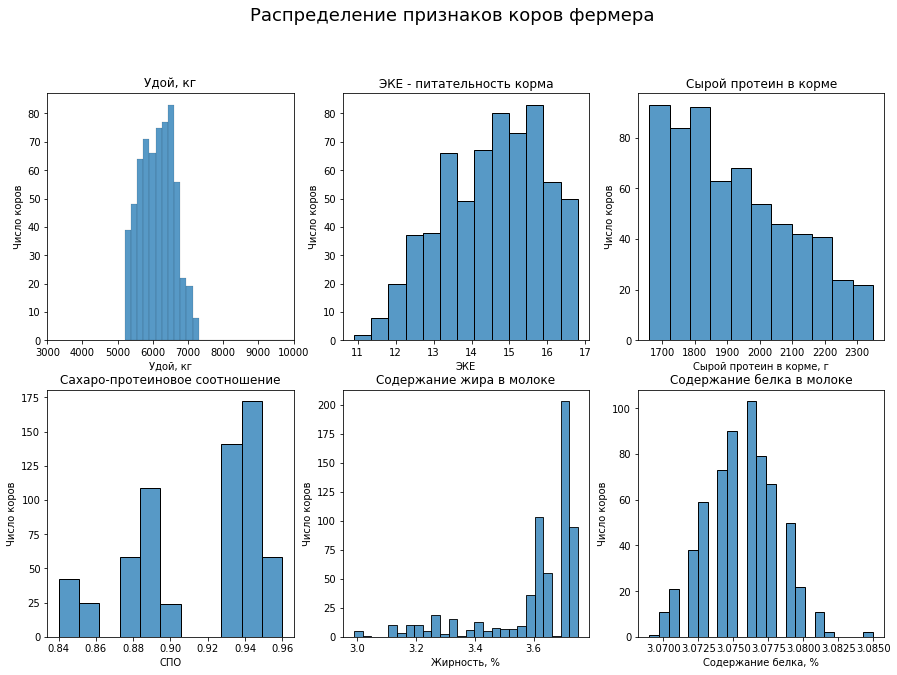

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Распределение признаков коров фермера' , fontsize=18,  y = 1)
hist_for_nums(ferma_main, num_cols_ferma)
axs[0, 0].set_title("Удой, кг")
axs[0, 0].set_xlabel("Удой, кг")
axs[0, 0].set_xlim(3000,10000)

axs[0, 1].set_title("ЭКЕ - питательность корма")
axs[0, 1].set_xlabel('ЭКЕ')

axs[0, 2].set_title("Сырой протеин в корме")
axs[0, 2].set_xlabel('Сырой протеин в корме, г')

axs[1, 0].set_title("Сахаро-протеиновое соотношение")
axs[1, 0].set_xlabel('СПО')

axs[1, 1].set_title("Содержание жира в молоке")
axs[1, 1].set_xlabel('Жирность, %')

axs[1, 2].set_title("Содержание белка в молоке")
axs[1, 2].set_xlabel('Содержание белка, %')

Text(0, 0.5, 'Содержание белка, %')

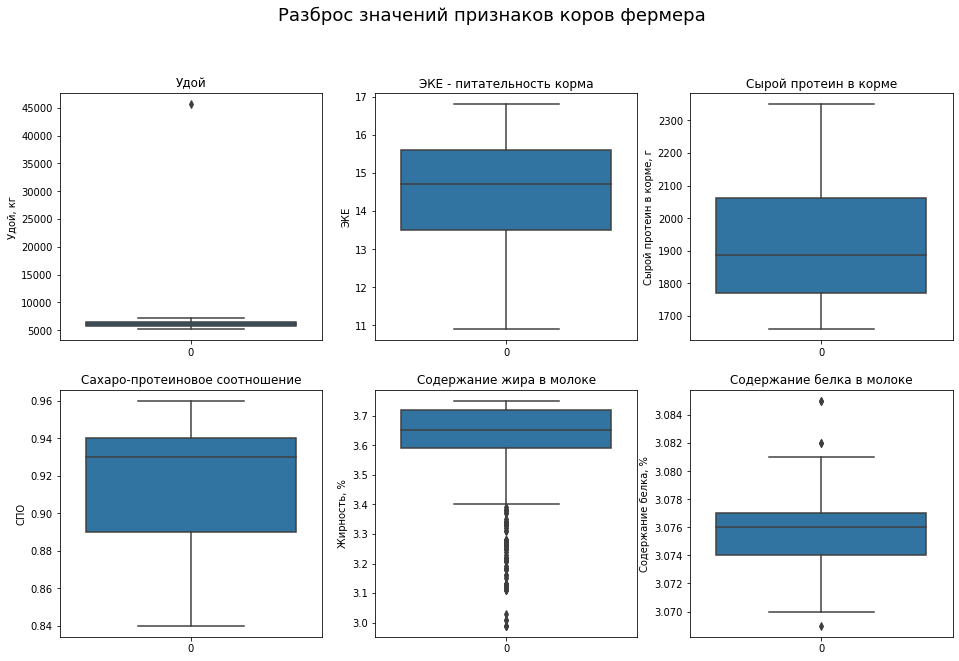

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
fig.suptitle('Разброс значений признаков коров фермера' , fontsize=18,  y = 1)
box_for_nums(ferma_main, num_cols_ferma)
axs[0, 0].set_title("Удой")
axs[0, 0].set_ylabel("Удой, кг")

axs[0, 1].set_title("ЭКЕ - питательность корма")
axs[0, 1].set_ylabel('ЭКЕ')

axs[0, 2].set_title("Сырой протеин в корме")
axs[0, 2].set_ylabel('Сырой протеин в корме, г')

axs[1, 0].set_title("Сахаро-протеиновое соотношение")
axs[1, 0].set_ylabel('СПО')

axs[1, 1].set_title("Содержание жира в молоке")
axs[1, 1].set_ylabel('Жирность, %')

axs[1, 2].set_title("Содержание белка в молоке")
axs[1, 2].set_ylabel('Содержание белка, %')

- С распределением удоя все нормально, есть один  выброс c величиной удоя более 45000 кг. Это значение не похоже на реальное, удалим его.

In [46]:
ferma_main = ferma_main.query('milk_yield <10000')
ferma_main.shape[0]

628

- Распределение питательности корма правдоподобно, выбросов нет.
- Распределение сырого протеина корма правдоподобно, выбросов нет. Большинство коров питается кормов, где относительно мало сырого протеина в корме. То есть среднее значение смещено в сторону меньших значений.
- Распределение СПО корма правдоподобно, выбросов нет. Среднее значение смещено к высоким значениям признака.
- Содержание жира в молоке для большиства коров фермера соответсвует диапазону 3.6-3.7%. Среднее значение сильно смещено в сторону относительно высокой жирности. При этом для 14% коров содержание жира в молоке находится в интервале 3.0-3.4%. Вероятно, высокие показатели жирности молока оптимальны и зависят от хорошего питания коровы. В зависимости от породы, кормов, режима содержания и просто индивидуальных особенностей коровы нмолоко может иметь жирность от 3,2 до 5,5 и даже 6%. Поэтому представленные значения адекватны и вполне реальны.


In [47]:
ferma_main.query('milk_fat<3.4').shape[0]/ferma_main.shape[0]

0.13694267515923567

- Распределение содержания белка в молоке в поголовье фермера близко к нормальному. Признак варьируется слабо - на сотые доли процента. Есть несколько выбросов: они не так уже сильно отличаются от средних величин содержания белка, не будем их убирать.

In [48]:
ferma_main.query('milk_protein<3.07 or milk_protein>=3.082')

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,breed,pasture,dad_breed,milk_fat,milk_protein,milk_taste,age
77,78,5871,14.7,1795,0.895,Вис Бик Айдиал,равнинное,Айдиал,3.61,3.082,вкусно,более_2_лет
240,241,5568,13.4,1733,0.880,Вис Бик Айдиал,равнинное,Соверин,3.63,3.069,не вкусно,менее_2_лет
426,427,6701,15.7,2068,0.940,РефлешнСоверинг,холмистое,Айдиал,3.72,3.082,вкусно,более_2_лет
471,472,5883,14.9,2159,0.890,Вис Бик Айдиал,равнинное,Соверин,3.62,3.085,вкусно,более_2_лет
517,518,5819,13.7,1968,0.840,Вис Бик Айдиал,холмистое,Айдиал,3.15,3.085,вкусно,более_2_лет


#### Характеристики коров для покупки с ЭкоФермы

Text(0.5, 0, 'Содержание белка, %')

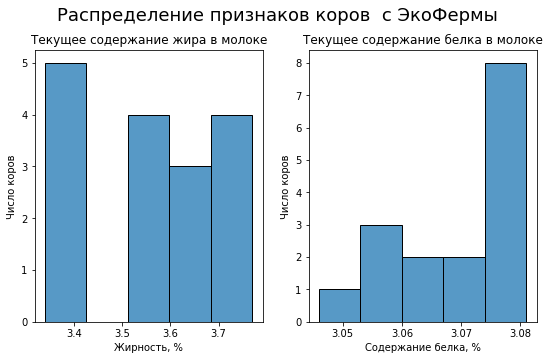

In [49]:
num_cols = cow_buy.select_dtypes(include='number')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
fig.suptitle('Распределение признаков коров  c ЭкоФермы' , fontsize=18,  y = 1)
hist_for_nums(cow_buy, num_cols)

axs[0].set_title("Текущее содержание жира в молоке")
axs[0].set_xlabel('Жирность, %')

axs[1].set_title("Текущее содержание белка в молоке")
axs[1].set_xlabel('Содержание белка, %')

Text(0, 0.5, 'Содержание белка, %')

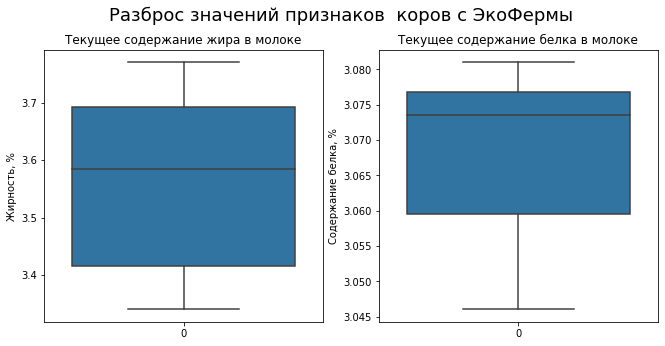

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
fig.suptitle('Разброс значений признаков  коров c ЭкоФермы' , fontsize=18,  y = 1)
box_for_nums(cow_buy, num_cols)
axs[0].set_title("Текущее содержание жира в молоке")
axs[0].set_ylabel('Жирность, %')

axs[1].set_title("Текущее содержание белка в молоке")
axs[1].set_ylabel('Содержание белка, %')

Сложно говорить о виде распределения, так как всего 16 объектов в датафрейме. Выбросов нет.
Характеристики коров фермера и коров с ЭкоФермы на первый взляд неплохо пересекаются, то есть интервал варьирования признака для коров с ЭкоФермы входит в этот интервал для коров заказчика, что хорошо для последующего обучения модели и предсказаний. 

### 3.2 Исследование категориальных данных

Для категориальных сделаем круговые диаграммы.

In [51]:
cat_cols_ferma = ferma_main.select_dtypes(exclude='number').columns
cat_cols_ferma

Index(['breed', 'pasture', 'dad_breed', 'milk_taste', 'age'], dtype='object')

In [52]:
def pie_for_cat(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        ax.pie(x = data.groupby(col)[col].count(), labels = data[col].unique(), autopct='%1.1f%%')
        ax.set_title(col)

#### Характеристика коров фермера

Text(0.5, 1.0, 'Возраст')

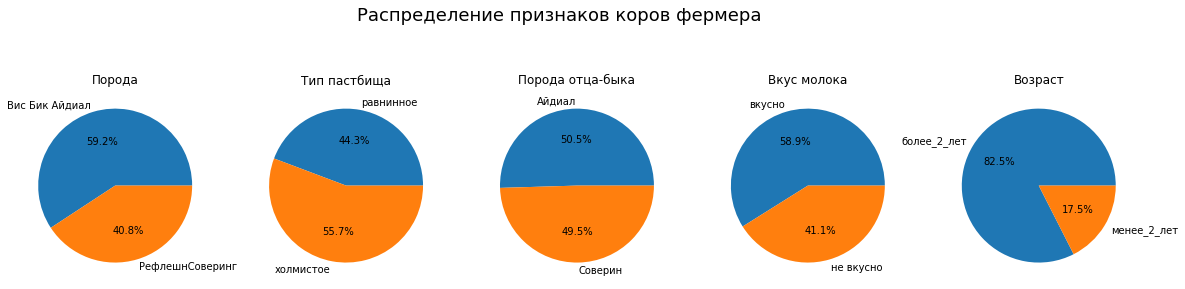

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle('Распределение признаков коров фермера' , fontsize=18,  y = 1)
pie_for_cat(ferma_main, cat_cols_ferma)
axs[0].set_title("Порода")

axs[1].set_title("Тип пастбища")

axs[2].set_title("Порода отца-быка")

axs[3].set_title("Вкус молока")

axs[4].set_title("Возраст")


- Всего две породы среди поголовья фермера. Больше половины - породы Вис Бик Айдиал.
- Два типа пастбищ. Более половины коров пасутся на холмистом пастбище. Выборка по признаку сбалансированная.
- Две породы.По двум группам коровы распределны примерно одинаково. Выборка по признаку сбалансированная.
- Поголовье фермера сбалансировано и по вкусу молока. Большинство коров дают вкусное молоко, но 41% - невкусное.
- Большинство коров фермера старше 2 лет.

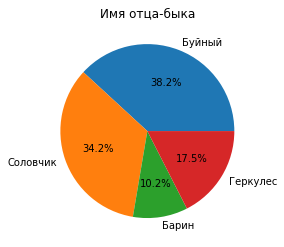

In [54]:
plt.title('Имя отца-быка')
plt.pie(x = ferma_dad.groupby('dad_name')['dad_name'].count(), labels = ferma_dad['dad_name'].unique(), autopct='%1.1f%%');

#### Характеристика коров с ЭкоФермы

In [55]:
cat_cols = cow_buy.select_dtypes(exclude='number').columns

Text(0.5, 1.0, 'Возраст')

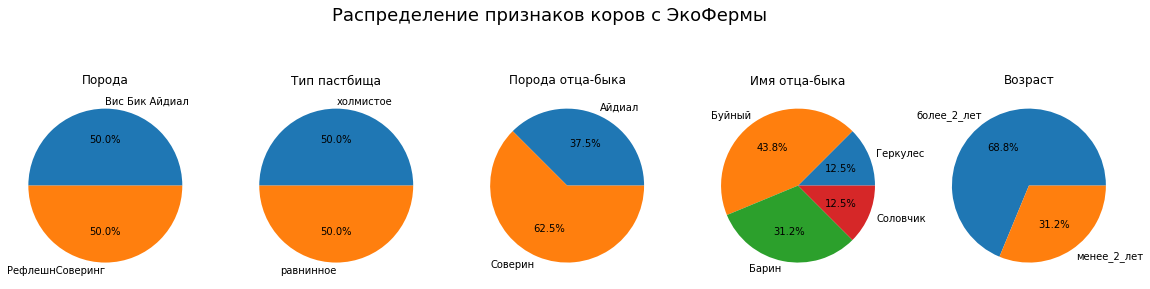

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle('Распределение признаков коров с ЭкоФермы' , fontsize=18,  y = 1)
pie_for_cat(cow_buy, cat_cols)
axs[0].set_title("Порода")

axs[1].set_title("Тип пастбища")

axs[2].set_title("Порода отца-быка")

axs[3].set_title("Имя отца-быка")

axs[4].set_title("Возраст")

- Быки-родители у коров заказчика и коров с Экофермы одни и те же. Но доля вклада каждого разнится.
- Коровы с ЭкоФермы тоже более менее сбалансировано разделены на соответсующие группы по выше перечиленным признакам.

### 3.3 Корреляционный анализ

- Посмотрим связь данных между собой с помощью диаграмм рассеяния.

Text(0.5, 1, 'Связь количественных переменных')

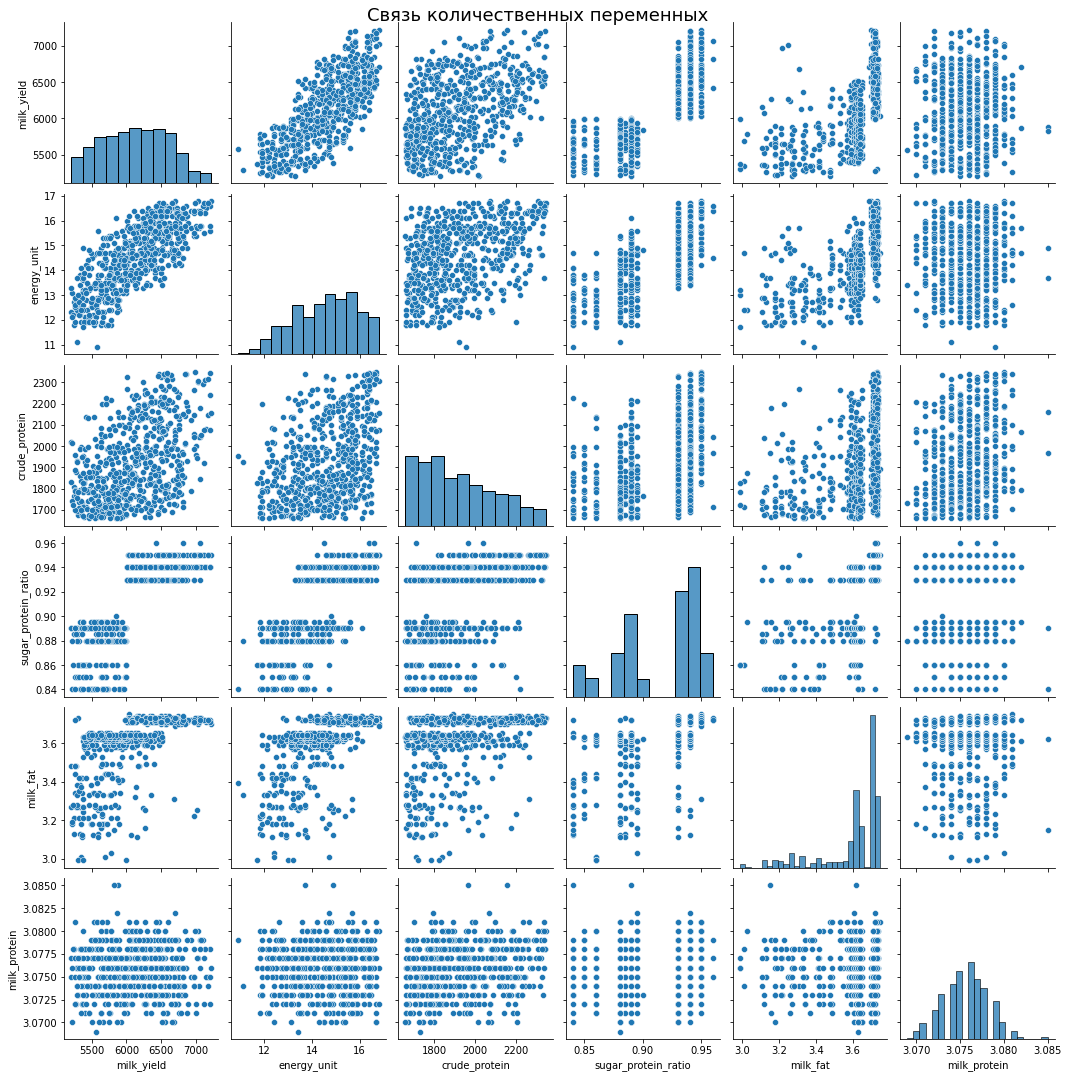

In [57]:
g = sns.pairplot(ferma_main[num_cols_ferma])
g.fig.suptitle('Связь количественных переменных', y=1,  fontsize=18)

На первый взгляд похоже, что удой зависит от питательности корма, количества сырого протеина в корме, сахаро-протеинового соотношения в корме. Чем выше значения этих признаков, тем больше удой. Между жирностью молока и удоем тоже прослеживается положительная зависимость.

Чем лучше питается корова, тем больше молока она дает. Высокая жирность молока это тоже признак, который косвенно говорит о том, что корова хорошо питается и получает все необходимое питательные вещества.

СПО и жирность молока связаны с удоей нелинейно - записи образуют группы скоплений при определенном значении признака, в других же  проимежуточных значенияй признака - нет ни одной записи. Для того, чтобы не исказить линейную модель нужно трансформировать эти признаки в категории (по группам-скопления на диаграмме рассеяния).

Похоже, что удой с ЭКЕ также связан нелинейно, зависимость представленно кривой , напоминает ветвь параболы.

- рассчитаем коэффициенты корреляции

In [58]:
ferma_main.corr()

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,milk_fat,milk_protein
id,1.000000,-0.006816,-0.028600,-0.035613,-0.064803,0.017126,0.002547
milk_yield,-0.006816,1.000000,0.765098,0.446731,0.806339,0.600902,0.002966
energy_unit,-0.028600,0.765098,1.000000,0.387875,0.749007,0.637279,-0.008939
crude_protein,-0.035613,0.446731,0.387875,1.000000,0.446332,0.357793,0.226802
sugar_protein_ratio,-0.064803,0.806339,0.749007,0.446332,1.000000,0.629098,0.073718
milk_fat,0.017126,0.600902,0.637279,0.357793,0.629098,1.000000,-0.026542
milk_protein,0.002547,0.002966,-0.008939,0.226802,0.073718,-0.026542,1.000000


Согласно коэффициенту корреляции Пирсона сильная корреляция между удоем и питательностью корма (ЭКЕ), сахаро-протеиновым соотношением (СПО), умеренная корреляция между удоем и количеством сырого протеина, жирностью молока.

Для переменных, чье распределение не соответствует нормальному, отдельно расчитаем коэффициент корреляции Спирмена.

In [59]:
ferma_main.corr(method='spearman')

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,milk_fat,milk_protein
id,1.000000,-0.003097,-0.022382,-0.037108,-0.021642,0.038631,0.003743
milk_yield,-0.003097,1.000000,0.765144,0.437543,0.787904,0.688506,-0.005701
energy_unit,-0.022382,0.765144,1.000000,0.384747,0.741962,0.686973,-0.013321
crude_protein,-0.037108,0.437543,0.384747,1.000000,0.485890,0.392822,0.229051
sugar_protein_ratio,-0.021642,0.787904,0.741962,0.485890,1.000000,0.701044,0.109924
milk_fat,0.038631,0.688506,0.686973,0.392822,0.701044,1.000000,0.043125
milk_protein,0.003743,-0.005701,-0.013321,0.229051,0.109924,0.043125,1.000000


In [60]:
for col in ['crude_protein', 'sugar_protein_ratio', 'milk_fat', 'age']:
    print(f'Коэффициент Спирмена для {col} и удоя равен {round(spearmanr(ferma_main.milk_yield, ferma_main[col])[0], 2)}')

Коэффициент Спирмена для crude_protein и удоя равен 0.44
Коэффициент Спирмена для sugar_protein_ratio и удоя равен 0.79
Коэффициент Спирмена для milk_fat и удоя равен 0.69
Коэффициент Спирмена для age и удоя равен -0.65


- **Таким образом**, в общем наборе данных о коровах фермера удой значительно связан с питательностью корма (ЭКЕ), сахаро-протеиновым соотношением (СПО), жирностью молока, в несколько меньшей степени с количеством сырого протеина в корме.
- Между удоем и питательностью корма, а также содержанием сырого протеина прослеживается положительная линейная зависимость. Причем, похоже питательность корма и количество сырого белка, а также питательность корма и СПО положительно коррелируют друг с другом.

Рассмотрим корреляции признаков в подгруппах:

1. для коров со вкусным и невкусным молоком

Text(0.5, 1.0, 'Матрица корреляций в подгруппах по вкусу молока')

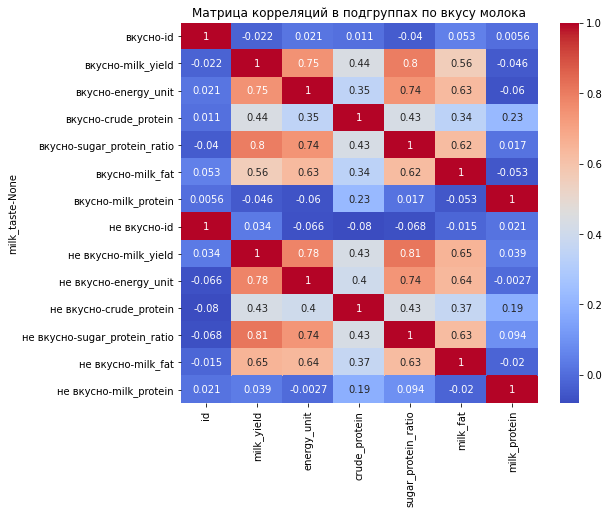

In [61]:
plt.figure(figsize = (8,7))
sns.heatmap(ferma_main.groupby('milk_taste').corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций в подгруппах по вкусу молока')

Для подгруппы коров с вкусным молоком вклад признака жирности молока в изменение велечины удоя немного меньше, чем для коров с невкусным молоком.

Text(0.5, 1.0, 'Матрица корреляций в подгруппах по породе коров')

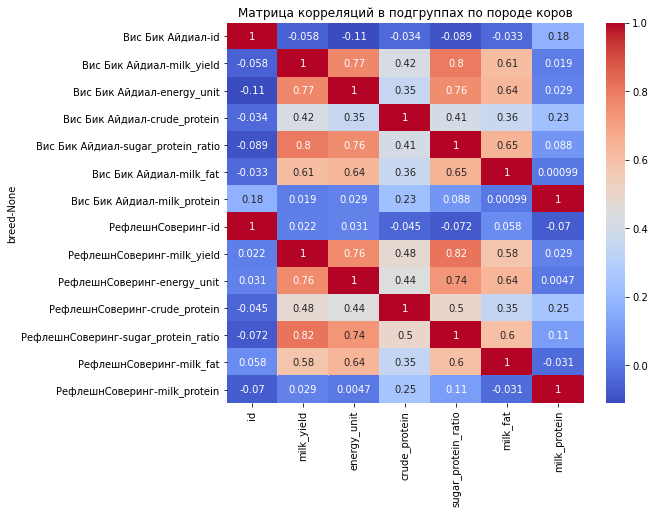

In [62]:
plt.figure(figsize = (8,7))
sns.heatmap(ferma_main.groupby('breed').corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций в подгруппах по породе коров')

Text(0.5, 1.0, 'Матрица корреляций в подгруппах по типу пастбища')

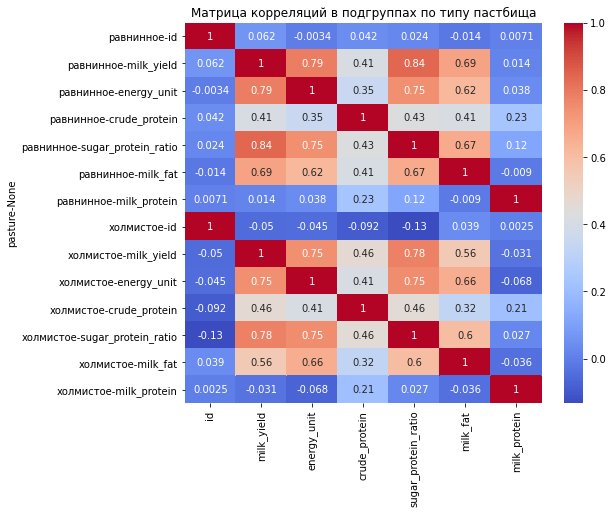

In [63]:
plt.figure(figsize = (8,7))
sns.heatmap(ferma_main.groupby('pasture').corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций в подгруппах по типу пастбища')

Тип пастбища  влияет на корреляцию удоя с жирностью молока, СПО.

Text(0.5, 1.0, 'Матрица корреляций в подгруппах по родительской породе')

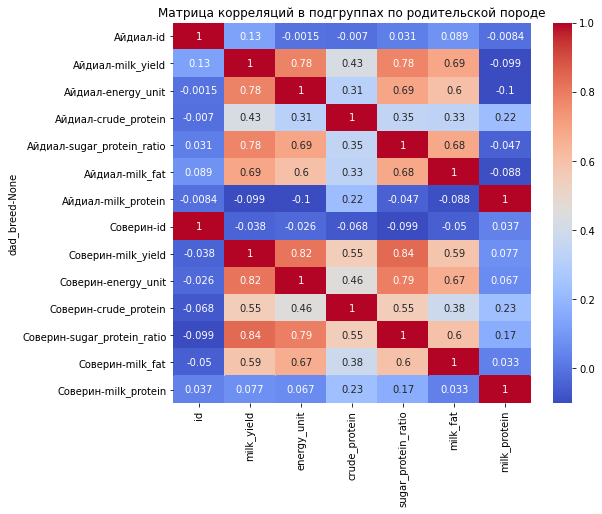

In [64]:
plt.figure(figsize = (8,7))
sns.heatmap(ferma_main.groupby('dad_breed').corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций в подгруппах по родительской породе')

У Подгруппы коров с родительской породой Соверин больше влияние количества сырого протеина, СПО на удой, чем у коров с родительской породой Айдиал.

Text(0.5, 1.0, 'Матрица корреляций в подгруппах по возрасту')

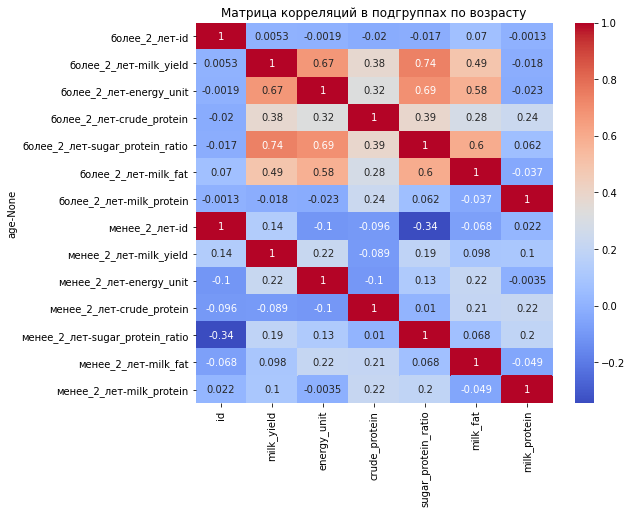

In [65]:
plt.figure(figsize = (8,7))
sns.heatmap(ferma_main.groupby('age').corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций в подгруппах по возрасту')

При группировке коров по возрасту видны наибольшие различия корреляций в группах. Удой у коров до 2 лет слабо зависит от изучаемых признаков. Это связано с тем, что коровы вообще редко дают молоко в возрасте до 2 лет, так как они еще не являются взрослыми особями и продолжают расти.

### 3.4 Вывод
- Распределение целевого признака (удой, кг) и  входных признаков *Питательность корма (ЭКЕ)* и *содержание белка в молоке* близко к нормальному распределению. Среднее значение *количества сырого протеина в корме* смещено в сторону меньших значений признака. В распределении *жирности молока* и *СПО* среднее значением смещено в сторону бОльших значений признака.
- В значениях *удоя* найдено одно аномально больше значение, которое убрали. 

- Анализ признаков коров с ЭкоФермы показал, что интервалы варьирования признаков в этом датасете значительно пересекаются с этими же признаками в таблице с данными о коровах фермера, что хорошо для обучения модели и точности прогнозов.
- Данные по категориальные признаки в датасетах сбалансированы.

- Удой зависит от питательности корма, количества сырого протеина в корме, сахаро-протеинового соотношения в корме. Чем выше значения этих признаков, тем больше удой. Между жирностью молока и удоем тоже прослеживается положительная зависимость. Чем лучше питается корова, тем больше молока она дает. Высокая жирность молока это тоже признак, который косвенно говорит о том, что корова хорошо питается и получает все необходимое питательные вещества, но при этом удой не может зависить от жирности молока.

- Между удоем и содержанием сырого протеина прослеживается положительная линейная зависимость. 

- СПО связано с удоем нелинейно - записи образуют группы скоплений при определенном значении признака, в других же  проимежуточных значенияй признака - нет ни одной записи. Для того, чтобы не исказить линейную модель нужно трансформировать признак в категории (по группам-скопления на диаграмме рассеяния).

- Удой с ЭКЕ также связан нелинейно, зависимость представленно кривой , напоминает ветвь параболы. Необходимо преобразовать значения в переменной, чтобы зависимость стала линейной.

- Питательность корма (ЭКЕ) и количество сырого белка, а также питательность корма и СПО положительно коррелируют друг с другом. Если взять за порог мультиколлинеарности значение коэффициента корреляции 0.9, то между признаками связь не настолько велика.


## 4. Обучение модели линейной регресии
### 4.1 Первая модель (без преобразований)
Задача - предсказать удой коров с ЭкоФермы

- подготовка данных к МО

Для обучения модели линейной регрессии возьмем из таблицы с данными коров фермера признаки, для которых мы выявили связь с удоем и которые непосредственно на него влияют. Жирность молока в обучении использовать не будем, так как это как и удой следствие хорошего питания. Возьмем три характеристики корма - ЭКЕ, СПО, количество сырого протеина.

А целевой признак - удой. 


In [66]:
X = ferma_main[['energy_unit','crude_protein', 'sugar_protein_ratio', 'age', 'breed', 'pasture', 'dad_breed' ]]
y = ferma_main.milk_yield

In [67]:
cat_col_names = ['age', 'breed', 'pasture', 'dad_breed']
num_col_names = ['energy_unit','crude_protein', 'sugar_protein_ratio']

X_train, X_test, y_train, y_test, scaler, encoder = get_ready(X,y, cat_col_names, num_col_names)

In [68]:
X_train.sample(5)

,x0_менее_2_лет,x1_РефлешнСоверинг,x2_холмистое,x3_Соверин,energy_unit,crude_protein,sugar_protein_ratio
184,0.0,1.0,1.0,1.0,1.043431,-0.038729,0.837130
410,1.0,0.0,0.0,1.0,-1.327796,1.161346,-0.703660
198,0.0,0.0,0.0,1.0,1.196413,1.657741,0.837130
23,1.0,0.0,0.0,1.0,-0.868849,-0.447845,0.528972
250,0.0,0.0,1.0,1.0,0.049045,-0.715134,-0.703660


Проверим масштаб количественных перменных после преобразований.

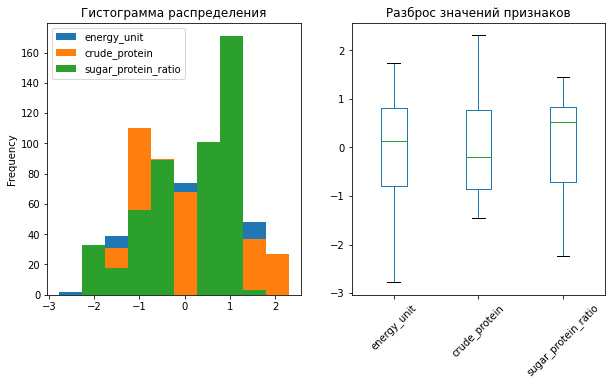

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

Все получилось.

- Обучение модели и оценка качества

In [70]:
lin_reg1 = LinearRegression()
lin_reg1.fit(X_train, y_train)
predictions = lin_reg1.predict(X_test)

In [71]:
metrics = pd.DataFrame()
metrics =metrics.append( lin_reg_metrics(y_test, predictions, 1))
metrics

,var_lin_reg,MAE,MSE,RMSE,R2
0,1,164.241945,43887.01501,209.492279,0.784408


- Ошибка прогноза по удою примерно 209 кг. 
- R2 0,78 показывает, что модель работает относительно хорошо. В 78% случаев прогнозируемое значение ближе к истине, чем среднее значение целевого признака.

Еще проанализируем остатки:

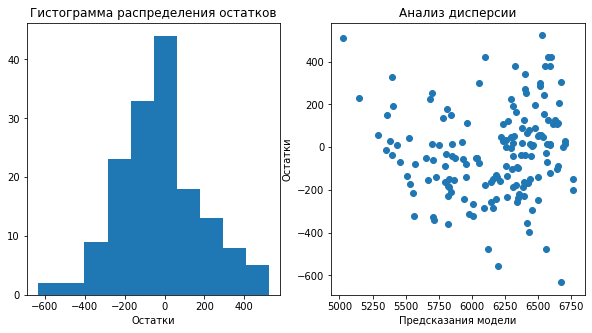

In [72]:
residuals(y_test,  predictions)

Распределение остатков похоже на нормальное, среднее значение слегка смещено в отрицательные значения. Значит модель может перепрогнозировать удой.
На диаграмме рассеивания видно, что дисперсия остатков слева на графике (до предсказаний удоя со значением 6000 кг) будет меньше, чем тех что справа от значения в 6000. 

#### **Вывод**

1. значение R2 модели равно 0.78. Это значит,что модель работает относительно хорошо. В 78% изменчивости таргета можно объяснить с помощью построенной модели относительно общнй изменчивости таргета.
2. Анализ остатков показал, что  модель может слегка перепрогнозировать целевой признак.
3. Повысить точность модели, можно преобразовав переменные СПО и ЭКЕ, как описывалось в п 3.4.

### 4.2 Второй вариант модели (после преобразования переменных)

#### 4.2.1 Перобразование переменных
Изменим переменные СПО и ЭКЕ, которые нелинейно связаны с целевой признаком - Удоем.

1. переведем СПО в категориальный признак, выявив и использовав границу нелинейности.

Text(0, 0.5, 'Удой, кг')

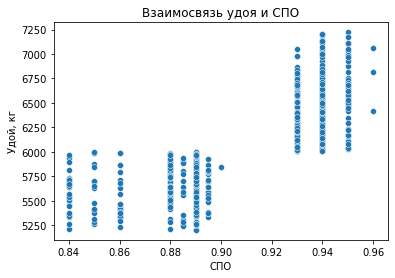

In [73]:
sns.scatterplot(x =ferma_main.sugar_protein_ratio, y =ferma_main.milk_yield )
plt.title('Взаимосвязь удоя и СПО')
plt.xlabel('СПО')
plt.ylabel('Удой, кг')

In [74]:
def spo_cat(spo):
    if spo > 0.92:
        return 'высокое'
    else:
        return 'низкое'

In [75]:
ferma_main['cat_sugar_protein_ratio'] = ferma_main.sugar_protein_ratio.apply(lambda x: 'высокое' if x > 0.92 else 'низкое' )

In [76]:
ferma_main['cat_sugar_protein_ratio'].value_counts()

высокое    370
низкое     258
Name: cat_sugar_protein_ratio, dtype: int64

2. Модифицируем переменную ЭКЕ - возведем в квадрат

In [77]:
ferma_main['energy_unit_squared'] = ferma_main.energy_unit.apply(np.square)

In [78]:
ferma_main[['energy_unit','energy_unit_squared']].head()

,energy_unit,energy_unit_squared
0,14.2,201.64
1,12.8,163.84
2,14.0,196.00
3,12.4,153.76
4,12.8,163.84


Text(0, 0.5, 'Удой, кг')

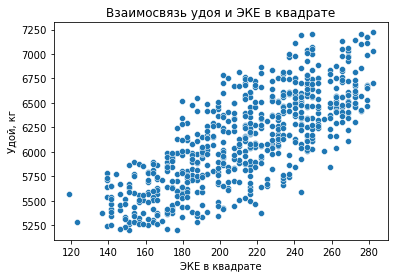

In [79]:

sns.scatterplot(x=ferma_main.energy_unit_squared, y =ferma_main.milk_yield  )
plt.title('Взаимосвязь удоя и ЭКЕ в квадрате')
plt.xlabel('ЭКЕ в квадрате')
plt.ylabel('Удой, кг')

In [80]:
ferma_main.energy_unit_squared.corr(ferma_main.milk_yield)

0.7655300782523304

Text(0, 0.5, 'Удой, кг')

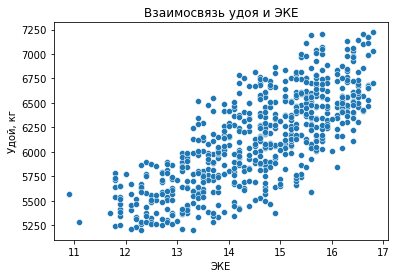

In [81]:
sns.scatterplot(x=ferma_main.energy_unit, y =ferma_main.milk_yield  )
plt.title('Взаимосвязь удоя и ЭКЕ')
plt.xlabel('ЭКЕ')
plt.ylabel('Удой, кг')

In [82]:
ferma_main.energy_unit.corr(ferma_main.milk_yield)

0.7650977877344265

In [83]:
ferma_main.energy_unit_squared.corr(ferma_main.milk_yield) - ferma_main.energy_unit.corr(ferma_main.milk_yield)

0.0004322905179039438

Зависимость признака после возведения в квадрат изменилась несильно. Коэффициент корреляции увеличился на 0.0004.

#### 4.2.2 Новая модель

In [84]:
X = ferma_main[['energy_unit_squared','crude_protein', 'cat_sugar_protein_ratio', 'age', 'breed', 'pasture', 'dad_breed' ]]
y = ferma_main.milk_yield

In [85]:
X.sample(5)

,energy_unit_squared,crude_protein,cat_sugar_protein_ratio,age,breed,pasture,dad_breed
512,179.56,1843,высокое,менее_2_лет,Вис Бик Айдиал,равнинное,Соверин
396,225.00,1739,высокое,более_2_лет,РефлешнСоверинг,холмистое,Соверин
526,234.09,1780,низкое,более_2_лет,РефлешнСоверинг,равнинное,Соверин
193,161.29,1875,низкое,менее_2_лет,Вис Бик Айдиал,равнинное,Айдиал
541,146.41,1835,низкое,более_2_лет,РефлешнСоверинг,холмистое,Айдиал


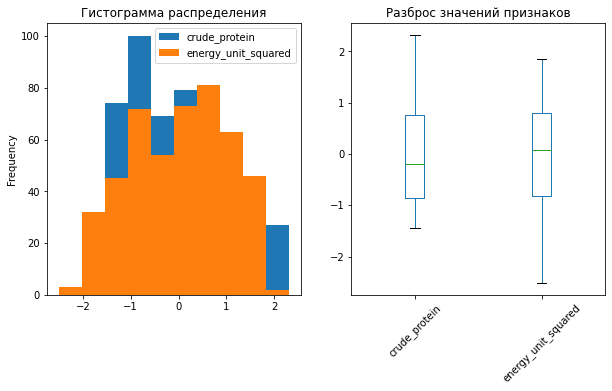

,x0_менее_2_лет,x1_РефлешнСоверинг,x2_холмистое,x3_Соверин,x4_низкое,crude_protein,energy_unit_squared
0,0.0,1.0,1.0,1.0,0.0,1.079523,1.577968
1,1.0,1.0,1.0,1.0,1.0,-0.196920,-1.511438
2,0.0,0.0,0.0,0.0,1.0,-1.386085,0.082269
3,0.0,0.0,1.0,0.0,0.0,0.752230,-0.150235
4,0.0,0.0,0.0,0.0,1.0,0.828598,-1.102358


In [86]:
# подготовка данных
cat_col_names = ['age', 'breed', 'pasture', 'dad_breed', 'cat_sugar_protein_ratio']
num_col_names = ['crude_protein', 'energy_unit_squared']
X_train, X_test, y_train, y_test,scaler, encoder = get_ready(X,y, cat_col_names, num_col_names)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

X_train.head()

Все ок, масштаб одинаковый, новые переменные на месте.

In [87]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train, y_train)
predictions = lin_reg2.predict(X_test)

metrics = metrics.append(lin_reg_metrics(y_test, predictions,2))
metrics

,var_lin_reg,MAE,MSE,RMSE,R2
0,1,164.241945,43887.015010,209.492279,0.784408
0,2,149.039652,37030.911311,192.434174,0.818088


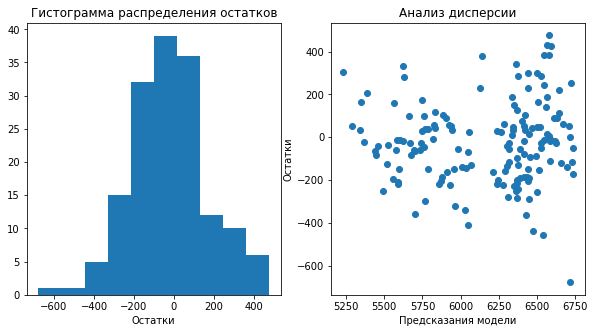

In [88]:
residuals(y_test,  predictions)

#### **Вывод**

Модель стала лучше. 
1. Ошибка меньше, значение R2 стало равным 0.81. Соответсвенно теперь чаще, чем раньше модель прогнозирует значение ближе к истине, чем среднее значение таргета. 
2. Среднее значение распределения остатков теперь находится ближе к нулю, но все еще смещено в сторону отрицательных значений. Дисперсия остатков стала более равномерной.

### 4.3 Третий вариант модели (добавили признак)
#### 4.3.1 Добавим новый признак
Добавим в данные для обучения признак - имя быка-отца.

Смерджим `ferma_main` и `ferma_dad`. 

In [89]:
ferma_main.shape[0]

628

In [90]:
ferma_main = ferma_main.merge(ferma_dad, how = 'inner', on = 'id')
ferma_main.head()

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,breed,pasture,dad_breed,milk_fat,milk_protein,milk_taste,age,cat_sugar_protein_ratio,energy_unit_squared,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,низкое,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,низкое,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,низкое,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,низкое,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,низкое,163.84,Барин


In [91]:
ferma_main.shape[0]

628

#### 4.3.2 Обучим новую модель

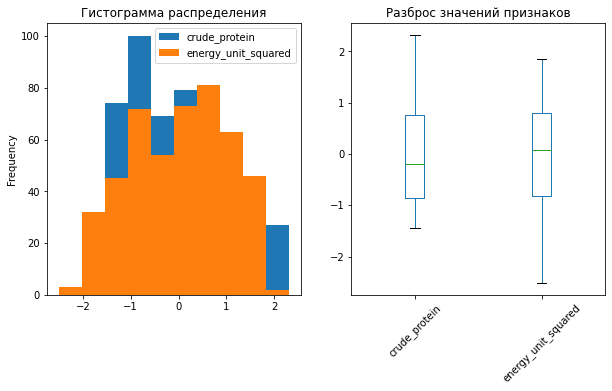

,x0_менее_2_лет,x1_РефлешнСоверинг,x2_холмистое,x3_Соверин,x4_низкое,x5_Буйный,x5_Геркулес,x5_Соловчик,crude_protein,energy_unit_squared
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.079523,1.577968
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-0.196920,-1.511438
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.386085,0.082269
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.752230,-0.150235
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.828598,-1.102358


In [92]:
X = ferma_main[['energy_unit_squared','crude_protein', 'cat_sugar_protein_ratio', 'age', 'breed', 'pasture', 'dad_breed', 'dad_name']]
y = ferma_main.milk_yield

# подготовка данных
cat_col_names = ['age', 'breed', 'pasture', 'dad_breed', 'cat_sugar_protein_ratio', 'dad_name']
num_col_names = ['crude_protein', 'energy_unit_squared']
X_train, X_test, y_train, y_test,scaler, encoder = get_ready(X,y, cat_col_names, num_col_names)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

X_train.head()

In [93]:
lin_reg3 = LinearRegression()
lin_reg3.fit(X_train, y_train)
predictions = lin_reg3.predict(X_test)

metrics = metrics.append( lin_reg_metrics(y_test, predictions,3))
metrics

,var_lin_reg,MAE,MSE,RMSE,R2
0,1,164.241945,43887.015010,209.492279,0.784408
0,2,149.039652,37030.911311,192.434174,0.818088
0,3,146.163024,35673.889886,188.875329,0.824754


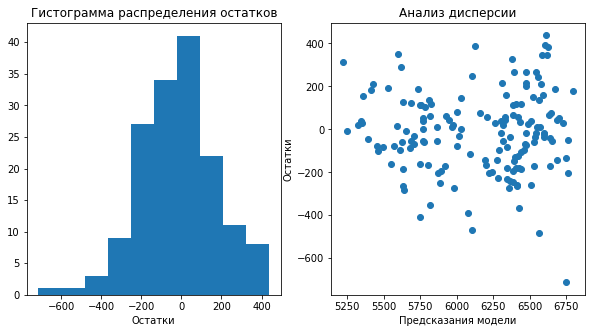

In [94]:
residuals(y_test,  predictions)

#### **Вывод**

Модель стала еще лучше!
1. Ошибка меньше, значение R2 стало равным 0.82 - повысился на 0.1 относительно второй модели. Модель еще чаще предсказывает значения близкие к истине.
2. Среднее значение распределения остатков теперь находится у нуля и никуда не смещено. Дисперсия остатков достаточно равномерная.

**Сравнивая все три модели** , обратившись к графикам и значениям MSE, MAE, RMSE и R2, видим, что все метрики улучшаются с внесением преобразований. 

Таким образом, **третья модель**, где добавили признак *Имя отца-быка* и постарались убрать нелинейную зависимость преобразованием переменных СПО (перевели в категорию), ЭКЕ (возвели в квадрат), **является самой точной**.

Доверительный интервал прогноза лучшей модели зависит от ошибки модели и будет равен **y_pred = y_true ± 189** , если берем как главную метрику ошибки RMSE.

### 4.4 Прогноз удоя коров к покупке

Дополним cow_buy данными и модифицированными переменными как в обучающей выборке.

In [95]:
cow_buy['energy_unit'] = ferma_main.energy_unit.mean()*1.05
cow_buy['crude_protein'] = ferma_main.crude_protein.mean()*1.05
cow_buy['sugar_protein_ratio'] = ferma_main.sugar_protein_ratio.mean()*1.05

In [96]:
cow_buy['cat_sugar_protein_ratio'] = cow_buy.sugar_protein_ratio.apply(lambda x: 'высокое' if x > 0.92 else 'низкое' )
cow_buy['energy_unit_squared'] = cow_buy.energy_unit.apply(np.square)
cow_buy.head()

,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,energy_unit,crude_protein,sugar_protein_ratio,cat_sugar_protein_ratio,energy_unit_squared
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138


Подготовим данные к предсказанию:

In [97]:
X_test = cow_buy[['energy_unit_squared','crude_protein', 'cat_sugar_protein_ratio', 'age', 'breed', 'pasture', 'dad_breed', 'dad_name']]
 # изменяем категории
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_test_scaled = scaler.transform(X_test[num_col_names])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_test.head()

,x0_менее_2_лет,x1_РефлешнСоверинг,x2_холмистое,x3_Соверин,x4_низкое,x5_Буйный,x5_Геркулес,x5_Соловчик,crude_protein,energy_unit_squared
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.517384,0.542248
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.517384,0.542248
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.517384,0.542248
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.517384,0.542248
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.517384,0.542248


In [98]:
X_test.shape[0]

16

Сделаем прогноз:

In [99]:
predictions = pd.Series(lin_reg3.predict(X_test))

In [100]:
predictions

0     6609.919297
1     6378.711028
2     6283.999775
3     6593.089377
4     6542.146066
5     6425.380218
6     6571.259737
7     6400.540668
8     6344.707860
9     6617.928926
10    6609.919297
11    6127.474742
12    6593.089377
13    6344.707860
14    6425.380218
15    6571.259737
dtype: float64

In [101]:
predictions[predictions>=6000].count()

16

Все 16 вариантов подходят.

In [102]:
cow_buy = cow_buy.reset_index()
cow_buy['predicted_milk_yield'] = predictions
cow_buy.query('predicted_milk_yield>=6000')

,index,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,energy_unit,crude_protein,sugar_protein_ratio,cat_sugar_protein_ratio,energy_unit_squared,predicted_milk_yield
0,0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6609.919297
1,1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6378.711028
2,2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6283.999775
3,3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6593.089377
4,4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6542.146066
5,5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6425.380218
6,7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6571.259737
7,9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6400.540668
8,10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6344.707860
9,11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6617.928926


Если учесть среднюю ошибку y_pred = y_true ± 189 и сделать прогноз точнее. Коровы с удоем более или равным 6189 кг практически точно подойдут фермеру. Таких коров на ЭкоФерме 15.

In [103]:
cow_buy.query('predicted_milk_yield>=6189').shape[0]

15

### 4.5 Вывод
- Для прогнозирования удоя коров выбрали модель линейной регресии. В качестве признаков-предикторов выбрали характеристики корма (ЭКЕ,СПО, количество сырого протеина), породу, возраст, породу отца-быка, тип пастбища. Целевая переменная - удой, кг. Выборку разделили на тренировочную и тестовую в соотношении 3 к 1. При подготовке данных к МО использовали стандартизацию мастштаба количественных переменных методом StandardScaler(), изменили представление в таблице категориальных признаков с помощью OneHotEncoder(). - Первичная базовая модель дала неплохие результаты точности и качества (RMSE = 209, R2 = 0.78), однако остатки распределены со смещением и их дисперсия не совсем равномерна.
- В результате устранения нелинейной зависимости таргета от ЭКЕ (возвели в квадрат) и СПО(перевели в категорию) получилось улучшить точность и качество модели (RMSE = 192, R2 = 0.818). Распределение остатков все еще немного смещено.
- Добавление нового признака - имя отца-быка - помогло сделать модель еще лучше: RMSE = 189, R2 = 0.825, остатки распределены наиболее близко к нормальному с центром в нуле, дисперсия остатков равномерна.
- На третьем - лучшей - модели спрогнозировали удой коров с ЭкоФермы, которых хотел бы приобрести фермер. Из всех только девять коров подходят под требование заказчика - удой должен быть не менее 6000 кг. А если учесть доверительный интервал  (± 189), то с наибольшей долей веротяности соответствовать требованию фермера будут 15 коров.

## 5. Обучение модели логистической регрессии
### 5.1 Подготовка данных и обучение
Задача - спрогнозировать вкусное ли молоко дает корова с ЭкоФермы.
Для решения задачи обучим модель логистической регрессии. 

Обучим модель на данных о коровах фермера - в первую очередь, это жирность и содержание белка в молоке, а также характеристики корма(ЭКЕ, СПО, количество сырого протеина, порода коровы, родительская порода, возраст, имя отца-быка и тип пастбища.

Целевая переменная - вкус молока (вкусно/не вкусно).

Сразу воспользуемся всеми теми улучшениями, что делали для модели в п.4.

In [104]:
ferma_main.sample(5)

,id,milk_yield,energy_unit,crude_protein,sugar_protein_ratio,breed,pasture,dad_breed,milk_fat,milk_protein,milk_taste,age,cat_sugar_protein_ratio,energy_unit_squared,dad_name
254,256,5780,12.7,1672,0.89,РефлешнСоверинг,холмистое,Соверин,3.27,3.077,вкусно,более_2_лет,низкое,161.29,Барин
161,163,5992,13.1,1676,0.86,Вис Бик Айдиал,холмистое,Айдиал,3.59,3.072,вкусно,более_2_лет,низкое,171.61,Буйный
387,389,6472,16.2,2073,0.93,РефлешнСоверинг,холмистое,Соверин,3.71,3.072,не вкусно,более_2_лет,высокое,262.44,Соловчик
604,606,6341,15.7,1923,0.94,РефлешнСоверинг,холмистое,Соверин,3.73,3.078,вкусно,более_2_лет,высокое,246.49,Соловчик
158,160,6262,14.4,1666,0.93,Вис Бик Айдиал,равнинное,Айдиал,3.59,3.075,вкусно,более_2_лет,высокое,207.36,Геркулес


Заменим значения классов таргета значениями 0 (не вкусно) и 1 (вкусно)

In [105]:
ferma_main['milk_taste_bin'] = ferma_main.milk_taste.apply(lambda x: 0 if x=='не вкусно' else 1)

In [106]:
X = ferma_main.drop(['id', 'milk_yield', 'energy_unit', 'sugar_protein_ratio', 'milk_taste', 'milk_taste_bin' ], axis = 1)
y = ferma_main.milk_taste_bin

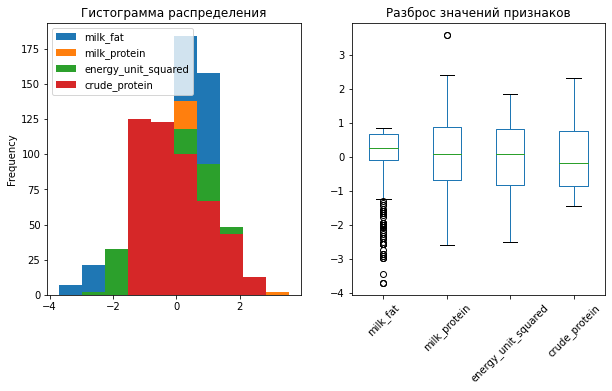

,x0_менее_2_лет,x1_РефлешнСоверинг,x2_холмистое,x3_Соверин,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_низкое,milk_fat,milk_protein,energy_unit_squared,crude_protein
0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.562532,-0.679069,1.577968,1.079523
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.601817,-1.452568,-1.511438,-0.196920
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-2.563750,1.254677,0.082269,-1.386085
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.081565,1.254677,-0.150235,0.752230
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.201807,0.094429,-1.102358,0.828598


In [107]:
cat_col_names = ['age', 'breed', 'pasture', 'dad_breed', 'dad_name',  'cat_sugar_protein_ratio']
num_col_names = ['milk_fat', 'milk_protein', 'energy_unit_squared','crude_protein']

X_train, X_test, y_train, y_test, scaler, encoder  = get_ready(X,y, cat_col_names, num_col_names)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

X_train.head()

In [108]:
log_r = LogisticRegression(random_state = 42)
log_r.fit(X_train, y_train)
predictions = log_r.predict(X_test)
metrics = clf_metrics(y_test, predictions, 'log_reg')

In [109]:
metrics

,clf,accuracy,precision,recall
0,log_reg,0.630573,0.622951,0.863636


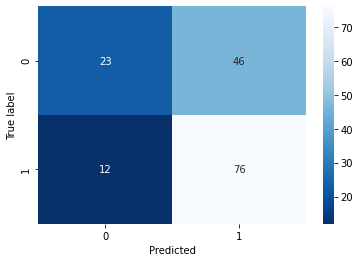

In [110]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Точность модели довольно низкая - 63%. 
Правильно определены как коровы со вкусным молоком - 76.
Правильно определены как коровы с невкусным молоком - 23.
Определены как коровы с вкусным молоком, но на деле это не так (ложноположительные) - 46.
Определены как коровы с невкусным молоком, но на деле наоборот (ложноотрицательные) - 12.

Для фермера критично, если он купит ту корову, которая по прогнозу соответсвует его требованиям, а  на самом деле нет. Так как он понесет финансовые издержки. Соотвественно необходимо минимизировать количество ложноположительных результатов прогноза - то есть значение Precision должно стремиться к единице, а количество ложноположительных результатов к нулю.

Рассчитаем метрики для случая, когда критическая ошибка (число ложноположительных результатов) будет равна 0. Для этого нужно изменить вероятность принадлежности к положительному классу. 

In [111]:
#сделаем список с разными порогами отнесения к положительному классу
thresholds = [round(i,2) for i in np.linspace(0.2,1,num = 10,endpoint=False)]
thresholds

[0.2, 0.28, 0.36, 0.44, 0.52, 0.6, 0.68, 0.76, 0.84, 0.92]

In [112]:
# массив с вероятностями отнесения записей к положительному классу
y_proba = log_r.predict_proba(X_test)[:,1]

In [113]:
# посмотрим самые высокие веротяности отнесения к классу
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data.head() 

,y_valid,y_proba
85,1,0.861355
110,1,0.842792
66,1,0.841488
51,1,0.839668
8,1,0.817304


Нет записей, для которых вероятность отнесения к положительному классу, была бы больше 0.861

In [114]:
# посмотрим как меняются прогнозируемые классы при смещении пороговой вероятности
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba'])
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>=i else 0)

In [115]:
data.head()

,y_valid,y_proba,y_pred_0.2,y_pred_0.28,y_pred_0.36,y_pred_0.44,y_pred_0.52,y_pred_0.6,y_pred_0.68,y_pred_0.76,y_pred_0.84,y_pred_0.92
0,1,0.671011,1,1,1,1,1,1,0,0,0,0
1,1,0.678809,1,1,1,1,1,1,0,0,0,0
2,1,0.654531,1,1,1,1,1,1,0,0,0,0
3,0,0.442702,1,1,1,1,0,0,0,0,0,0
4,1,0.794017,1,1,1,1,1,1,1,1,0,0


In [116]:
#посмотрим как при изменении порога меняеться precision и количество истинно положительный и ложноположительных результатов прогноза
threshold_search1 = pd.DataFrame()
y_test = y_test.reset_index(drop=True)
for i in thresholds:
    y_pred = pd.Series(y_proba).apply(lambda x: 1 if x>=i else 0)
    df = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
    TP = df[(df['y_pred']==1) & (df['y_test']==1)].shape[0]
    FP = df[(df['y_pred']==1) & (df['y_test']==0)].shape[0]
    
    #y_pred = data['y_proba'].apply(lambda x: 1 if x>=i else 0)
    precision = precision_score(y_test,y_pred)
    temp = pd.DataFrame({'Порог' : ['y_pred_'+str(i)],
                         'precision':[precision],
                         'TP': [TP],
                         'FP': [FP]
                         })
    threshold_search1 = threshold_search1.append(temp)

In [117]:
threshold_search1

,Порог,precision,TP,FP
0,y_pred_0.2,0.560510,88,69
0,y_pred_0.28,0.564103,88,68
0,y_pred_0.36,0.565517,82,63
0,y_pred_0.44,0.577778,78,57
0,y_pred_0.52,0.625000,75,45
0,y_pred_0.6,0.723404,68,26
0,y_pred_0.68,0.807692,42,10
0,y_pred_0.76,0.863636,19,3
0,y_pred_0.84,1.000000,3,0
0,y_pred_0.92,0.000000,0,0


Искомое значение порога где-то между веротяностями 0.76 и 0.84.

Уточним порог. Возьмем более узкий интервал значений и детально его изучим.

In [118]:
#уточненные значения порога
new_threshold = [round(i,2) for i in np.linspace(0.76,0.84,num = 10,endpoint=False)]

In [119]:
#посмотрим изменения метрик при новых значениях порога
threshold_search2 = pd.DataFrame()
y_test = y_test.reset_index(drop=True)
for i in new_threshold:
    y_pred = pd.Series(y_proba).apply(lambda x: 1 if x>=i else 0)
    df = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
    TP = df[(df['y_pred']==1) & (df['y_test']==1)].shape[0]
    FP = df[(df['y_pred']==1) & (df['y_test']==0)].shape[0]
    
    #y_pred = data['y_proba'].apply(lambda x: 1 if x>=i else 0)
    precision = precision_score(y_test,y_pred)
    temp = pd.DataFrame({'Порог' : ['y_pred_'+str(i)],
                         'precision':[precision],
                         'TP': [TP],
                         'FP': [FP]
                         })
    threshold_search2 = threshold_search2.append(temp)

In [120]:
threshold_search2

,Порог,precision,TP,FP
0,y_pred_0.76,0.863636,19,3
0,y_pred_0.77,0.857143,18,3
0,y_pred_0.78,0.812500,13,3
0,y_pred_0.78,0.812500,13,3
0,y_pred_0.79,0.769231,10,3
0,y_pred_0.8,0.888889,8,1
0,y_pred_0.81,1.000000,6,0
0,y_pred_0.82,1.000000,4,0
0,y_pred_0.82,1.000000,4,0
0,y_pred_0.83,1.000000,4,0


Порог вероятности отнесения к положительному классу для условия отсутствия ложноположительных результатов составляет **0.81.**

Соответственно для наиболее точного согласно метрики precision прогноза нужно взять порог веротяности отнесения к положительному классу 0.81, а не 0.5, как взят по умолчанию.
Такой порог нужно будет применить при работе с данными cow_buy.

### 5.2 Прогноз вкуса молока коров к покупке

Внесем в таблицу cow_buy необходимые изменения.

In [121]:
cow_buy.sample(5)

,index,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,energy_unit,crude_protein,sugar_protein_ratio,cat_sugar_protein_ratio,energy_unit_squared,predicted_milk_yield
13,16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6344.707860
7,9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6400.540668
0,0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6609.919297
12,15,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6593.089377
11,13,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6127.474742


In [122]:
num_col_names = ['current_milk_fat', 'current_milk_protein', 'energy_unit_squared', 'crude_protein']

In [123]:
X_test = cow_buy.drop(['index', 'predicted_milk_yield', 'energy_unit', 'sugar_protein_ratio' ], axis = 1)

In [124]:
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_test_scaled = scaler.transform(X_test[num_col_names])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)


In [125]:
X_test.head()

,x0_менее_2_лет,x1_РефлешнСоверинг,x2_холмистое,x3_Соверин,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_низкое,current_milk_fat,current_milk_protein,energy_unit_squared,crude_protein
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.158918,0.094429,0.542248,0.517384
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.399401,2.028176,0.542248,0.517384
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.098797,-0.679069,0.542248,0.517384
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.241093,-5.706810,0.542248,0.517384
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.201807,-0.679069,0.542248,0.517384


Такой прогноз классов получается при пороговой вероятности 0.5:

In [126]:
predictions = pd.Series(log_r.predict(X_test))

In [127]:
predictions.value_counts()

1    9
0    7
dtype: int64

Девять определена как коровы с вкусным молоком, семь - с невкусным.

Однако нам надо применить порог 0.81, что снизить до нуля количество ложноположительных результатов.

In [128]:
log_r.predict_proba(X_test)[:, 1]

array([0.70802812, 0.65988158, 0.57149083, 0.3633716 , 0.5557968 ,
       0.10416201, 0.65949201, 0.74205251, 0.16590165, 0.51611719,
       0.10314161, 0.66085542, 0.46109975, 0.69298422, 0.10256724,
       0.41999125])

In [129]:
y_pred_new_threshold = (log_r.predict_proba(X_test)[:, 1] >= 0.81).astype(int)
y_pred_new_threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Если берем порог 0.81, то ни одна корова не будет отнесена к положительному классу. Таким образом, наша модель не дает возможности точно выбрать корову с кусным молоком. Можно попробовать немного уменьшить, чтобы появились не 100%-веротяные , но хоть какие-то достаточно вероятные варианты. 

In [130]:
new_threshold = [round(i,2) for i in np.linspace(0.6,0.84,num = 10,endpoint=False)]
threshold_search = pd.DataFrame()
for i in new_threshold:
    positive_var = np.sum((log_r.predict_proba(X_test)[:, 1] >= i).astype(int))
    temp = pd.DataFrame({'Порог' : ['y_pred_'+str(i)],
                         'Число коров с вкусным молоком':[positive_var]
                         })
    threshold_search = threshold_search.append(temp)
threshold_search

,Порог,Число коров с вкусным молоком
0,y_pred_0.6,6
0,y_pred_0.62,6
0,y_pred_0.65,6
0,y_pred_0.67,3
0,y_pred_0.7,2
0,y_pred_0.72,1
0,y_pred_0.74,1
0,y_pred_0.77,0
0,y_pred_0.79,0
0,y_pred_0.82,0


In [131]:
#посмотрим изменения метрик при новых значениях порога
threshold_search2 = pd.DataFrame()
y_test = y_test.reset_index(drop=True)
for i in new_threshold:
    y_pred = pd.Series(y_proba).apply(lambda x: 1 if x>=i else 0)
    df = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
    TP = df[(df['y_pred']==1) & (df['y_test']==1)].shape[0]
    FP = df[(df['y_pred']==1) & (df['y_test']==0)].shape[0]
    
    #y_pred = data['y_proba'].apply(lambda x: 1 if x>=i else 0)
    precision = precision_score(y_test,y_pred)
    temp = pd.DataFrame({'Порог' : ['y_pred_'+str(i)],
                         'precision':[precision],
                         'TP': [TP],
                         'FP': [FP]
                         })
    threshold_search2 = threshold_search2.append(temp)
threshold_search2

,Порог,precision,TP,FP
0,y_pred_0.6,0.723404,68,26
0,y_pred_0.62,0.773810,65,19
0,y_pred_0.65,0.769231,50,15
0,y_pred_0.67,0.789474,45,12
0,y_pred_0.7,0.822222,37,8
0,y_pred_0.72,0.815789,31,7
0,y_pred_0.74,0.866667,26,4
0,y_pred_0.77,0.857143,18,3
0,y_pred_0.79,0.769231,10,3
0,y_pred_0.82,1.000000,4,0


In [132]:
threshold_search = threshold_search.merge(threshold_search2, on = 'Порог') 
threshold_search

,Порог,Число коров с вкусным молоком,precision,TP,FP
0,y_pred_0.6,6,0.723404,68,26
1,y_pred_0.62,6,0.773810,65,19
2,y_pred_0.65,6,0.769231,50,15
3,y_pred_0.67,3,0.789474,45,12
4,y_pred_0.7,2,0.822222,37,8
5,y_pred_0.72,1,0.815789,31,7
6,y_pred_0.74,1,0.866667,26,4
7,y_pred_0.77,0,0.857143,18,3
8,y_pred_0.79,0,0.769231,10,3
9,y_pred_0.82,0,1.000000,4,0


Возьмем порог 0.7, чтоб хотя бы два коровы по прогнозу имели вкусное молоко. Precision при этом значении будет равным 0.76 - с вероятностью 0.76 это правильно спргнозированные пложительные результаты, с вероятностью 0.24 эти разультаты являются ложноположительными.

In [133]:
y_pred_new_threshold = (log_r.predict_proba(X_test)[:, 1] >= 0.7).astype(int)
predictions = y_pred_new_threshold 

In [134]:
cow_buy['predicted_milk_taste_bin'] = predictions
cow_buy['predicted_milk_taste'] = cow_buy['predicted_milk_taste_bin'].apply(lambda x: 'вкусно' if x==1 else 'не вкусно')
cow_buy = cow_buy.drop('predicted_milk_taste_bin', axis =1)

In [135]:
cow_buy.head()

,index,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,energy_unit,crude_protein,sugar_protein_ratio,cat_sugar_protein_ratio,energy_unit_squared,predicted_milk_yield,predicted_milk_taste
0,0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6609.919297,вкусно
1,1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6378.711028,не вкусно
2,2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6283.999775,не вкусно
3,3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6593.089377,не вкусно
4,4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6542.146066,не вкусно


In [136]:
cow_buy.query('predicted_milk_taste == "вкусно"')

,index,breed,pasture,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,energy_unit,crude_protein,sugar_protein_ratio,cat_sugar_protein_ratio,energy_unit_squared,predicted_milk_yield,predicted_milk_taste
0,0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6609.919297,вкусно
7,9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,высокое,233.361138,6400.540668,вкусно


In [137]:
for_farmer = cow_buy.query('predicted_milk_yield >= 6186 and predicted_milk_taste == "вкусно"'). \
drop(['energy_unit','crude_protein',
      'sugar_protein_ratio','cat_sugar_protein_ratio',
      'energy_unit_squared'], axis = 1).\
reset_index(drop=True)
for_farmer.columns = ['Номер в исходной таблице', 'Порода', 'Тип пастбища', 'Порода отца-быка', 'Имя отца-быка', 'Текущее содержание белка в молоке', 
                      'Текущее содержание жира в молоке', 'Возраст', 'Прогнозируемый удой, кг в год', 'Прогнозируемый вкус молока']

In [138]:
for feature_number, feature_name in enumerate(X_test.columns):
    weight = log_r.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}")

x0_менее_2_лет      : -0.204374
x1_РефлешнСоверинг  : +0.039923
x2_холмистое        : +0.501364
x3_Соверин          : -0.037825
x4_Буйный           : -0.095495
x4_Геркулес         : -0.105027
x4_Соловчик         : -0.424116
x5_низкое           : +0.717791
current_milk_fat    : -0.020444
current_milk_protein: +0.261697
energy_unit_squared : +0.614456
crude_protein       : +0.170151


Наиболее важными параметрами модели, влияющими на прогноз, являются  **уровень СПО, тип пастбища и питательность корма (ЭКЕ).**

Девять определена как коровы с вкусным молоком, семь - с невкусным.

Однако нам надо применить порог 0.81, что снизить до нуля количество ложноположительных результатов.

### 5.3 Вывод

- Обучив модель на данных о коровах фермера - в первую очередь, это жирность и содержание белка в молоке, а также характеристики корма(ЭКЕ, СПО, количество сырого протеина, порода коровы, родительская порода, возраст, имя отца-быка и тип пастбища, с учетом всех преобразований перемнных для исключения нелинейности получили модель с точностью accuracy 63%. Модель верно прогнозирует коров со вкусным молоком в 62% случаев (precision 0.62), соотвественно в 38% случаев ошибается и прогнозирует невкусное молоко как вкусное.  В 14 % случаев модель относит вкусное молоко к противоположному классу (recall 0.86). 

- Так как фермеру важно не переплатить за коров, которые ему не подходят, необходимо сократить до нуля количество ложноположительных вариантов. Для этого при пригнозе используем порог вероятности отнесения к положительному классу равный 0.81. 

- При прогнозировании вкуса молока коров с Экофермы с порогом по умолчанию (0.5) получили, что восемь коров имеют вкусное молоко, одна вероятность ошибки велика. Если увеличить порог до 0.81, то согласно нащей модели ни одна корова не обладает вкусным молоком. Соотвественно, мы не можем с 100% уверенностью помочь фермеру выбрать корову с вкусным молоком. 
- Однако если принять некоторые риски (взять порог 0.70), то можно выделить хотя бы три коровы с вкусным молоком. Правда, с вероятностью 24% есть риск, что хотя бы одна корова будет давать невкусное молоко.
-  Наибольший вклад в прогнозирование вкуса молока имеют признаки уровень СПО, тип пастбища и питательность корма (ЭКЕ).

## 6. Итоговый вывод исследования

1. **Обзор данных**
- Данные в трех таблицах соответствуют описанию задачи. Таблица `ferma_main.csv` представляет собой 634 записи о характеристиках коров с фермы заказчика проекта. По id коров таблица `ferma_dad` связана с `ferma_main` и содержит имена быков-отцов коров из таблицы `ferma_main`. В таблице `cow_buy` с данными о коровах с ЭкоФермы для покупки 20 записей и 7 столбцов с характеристиками теми же, что и представлены в таблице `ferma_main` за исключением вкуса молока, удоя , сведений о корме.
- Ни в одной таблице нет пропусков.
- Во всех таблицах нужно соотвествующе общепринятому стилю изменить названия столбцов.

2. **Предобработка данных**
- Переименовали столбцы во всех таблицах: представили их на латинице змеиным регистром.
- Дополнительно проверили наличие пропусков. Их не обнаружено.
- Убрали явные дубликаты из таблиц `ferma_main`(5 строк), `cow_buy` (4 строки).
- Убрали неявные дубликаты из столбцов `pasture`, `dad_breed` в таблице `ferma_main`.

3. **Исследовательский анализ данных**

а. Распределения признаков

- Распределение целевого признака (удой, кг) и  входных признаков *Питательность корма (ЭКЕ)* и *содержание белка в молоке* близко к нормальному распределению. Среднее значение *количества сырого протеина в корме* смещено в сторону меньших значений признака. В распределении *жирности молока* и *СПО* среднее значением смещено в сторону бОльших значений признака.
- В значениях *удоя* найдено одно аномально больше значение, которое убрали. 
- Анализ признаков коров с ЭкоФермы показал, что интервалы варьирования признаков в этом датасете значительно пересекаются с этими же признаками в таблице с данными о коровах фермера, что хорошо для обучения модели и точности прогнозов.
- Данные по категориальные признаки в датасетах сбалансированы.

б. Корреляционный анализ
- Удой зависит от питательности корма, количества сырого протеина в корме, сахаро-протеинового соотношения в корме. Чем выше значения этих признаков, тем больше удой. Между жирностью молока и удоем тоже прослеживается положительная зависимость. Чем лучше питается корова, тем больше молока она дает. Высокая жирность молока это тоже признак, который косвенно говорит о том, что корова хорошо питается и получает все необходимое питательные вещества, но при этом удой не может зависить от жирности молока.

- Между удоем и содержанием сырого протеина прослеживается положительная линейная зависимость. 

- СПО связано с удоем положительно , но нелинейно. Для того, чтобы не исказить линейную модель нужно трансформировать признак в категории (по группам-скопления на диаграмме рассеяния). Удой с ЭКЕ также связан положительно и нелинейно, зависимость представленно кривой , напоминает ветвь параболы. Необходимо преобразовать значения в переменной, чтобы зависимость стала линейной.

- Питательность корма (ЭКЕ) и количество сырого белка, а также питательность корма и СПО положительно коррелируют друг с другом. Если взять за порог мультиколлинеарности значение коэффициента корреляции 0.9, то между признаками связь не настолько велика.

4. **Модель линейной регресси для прогноза удоя коров**

- Для прогнозирования удоя коров выбрали модель линейной регресии. В качестве признаков-предикторов выбрали характеристики корма (ЭКЕ,СПО, количество сырого протеина), породу, возраст, породу отца-быка, тип пастбища. Целевая переменная - удой, кг. Выборку разделили на тренировочную и тестовую в соотношении 3 к 1. При подготовке данных к МО использовали стандартизацию мастштаба количественных переменных методом StandardScaler(), изменили представление в таблице категориальных признаков с помощью OneHotEncoder(). - Первичная базовая модель дала неплохие результаты точности и качества (RMSE = 208, R2 = 0.78), однако остатки распределены со смещением и их дисперсия не совсем равномерна.
- В результате устранения нелинейной зависимости таргета от ЭКЕ (возвели в квадрат) и СПО(перевели в категорию) получилось улучшить точность и качество модели (RMSE = 192, R2 = 0.818). Распределение остатков все еще немного смещено.
- Добавление нового признака - имя отца-быка - помогло сделать модель еще лучше: RMSE = 189, R2 = 0.825, остатки распределены наиболее близко к нормальному с центром в нуле, дисперсия остатков равномерна.
- *На третьем - лучшей - модели спрогнозировали удой коров с ЭкоФермы, которых хотел бы приобрести фермер. Из всех только девять коров подходят под требование заказчика - удой должен быть не менее 6000 кг. А если учесть доверительный интервал  (± 189), то с наибольшей долей веротяности соответствовать требованию фермера будут 15 коров.*

5. **Модель линейной регресси для прогноза вкуса молока**

- Обучив модель на данных о коровах фермера - в первую очередь, это жирность и содержание белка в молоке, а также характеристики корма(ЭКЕ, СПО, количество сырого протеина, порода коровы, родительская порода, возраст, имя отца-быка и тип пастбища, с учетом всех преобразований переменных для исключения нелинейности получили модель с точностью accuracy 63%. Модель верно прогнозирует коров со вкусным молоком в 62% случаев (precision 0.62), соотвественно в 38% случаев ошибается и прогнозирует невкусное молоко как вкусное.  В 14 % случаев модель относит вкусное молоко к противоположному классу (recall 0.86). 

- Так как фермеру важно не переплатить за коров, которые ему не подходят, необходимо сократить до нуля количество ложноположительных вариантов и соотвественно максимально повысим уровень метрики precision. Для этого при пригнозе используем порог вероятности отнесения к положительному классу равный 0.81.

- Метрики precision и  recall важны при анализе рисков. В зависимости от бизнес-задачи может быть необходимость повысить уровень recall (минимизировать отнесение истинных положительных значений к отрицательному классу FN), и наоборот - повысить уровень precision (минимизировать отнесение  отрицательных значений к положительному классу FP). В первом случае, важно найти все реальные положительные результаты и не так важно сколько раз мы примем за положительный отрицательный результат. А во втором случае, важно найти только реально положительные результаты и не ошибиться в выборе положительных результатов, чтобы,например, сэкономить финансы.

- *При прогнозировании вкуса молока коров с Экофермы с порогом по умолчанию (0.5) получили, что девять коров имеют вкусное молоко, одна вероятность ошибки велика. Если увеличить порог до 0.81, то согласно нашей модели ни одна корова не обладает вкусным молоком. Соотвественно, мы не можем с 100% уверенностью помочь фермеру выбрать корову с вкусным молоком.*
- *Однако если принять некоторые риски (взять порог 0.70), то можно выделить хотя бы три коровы с вкусным молоком. Правда, с вероятностью 24% есть риск (precision = 0.76), что какая-то из купленных коров будет давать невкусное молоко.*

- Улучшить качество и точность регрессионных моделей можно было бы за счет увеличения тренировочной выборки, подбора гиперпараметров модели, добавления новых признаков.

6. **Рекомендации для заказчика**

Согласно требованиям (годовой удой не менее 6000 кг и вкусное молоко) среди коров ЭкоФермы найдено два варианта к покупке. В таблице ниже приведены коровы рекомендуемые к покупке.


In [139]:
for_farmer

,Номер в исходной таблице,Порода,Тип пастбища,Порода отца-быка,Имя отца-быка,Текущее содержание белка в молоке,Текущее содержание жира в молоке,Возраст,"Прогнозируемый удой, кг в год",Прогнозируемый вкус молока
0,0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6609.919297,вкусно
1,9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6400.540668,вкусно


- По годовому удою коровы подобраны достаточно точно, во избежание рисков учтена ошибка модели - подобраны варианты с прогнозируемым удоем не менее 6186 кг в год. 
- Точность выбора коров со вкусным молоком не максимальна, есть риск (вероятность 0.24), что среди них будут коровы с невкусным молоком. Со 100% уверенностью не может выбрать ни одну корову из предложенных. 
- Чтобы найти более подходящих коров, можно найти допонительные предложения для покупки. Это повысит вероятность найти более подходящие требованиям варианты (особенно по вкусу молока) с минимальным риском. Или увеличить выборку для обучения, добавить признаки, чтобы улучшить качество модели.